# Проверить гипотезы по увеличению выручки для крупного интернет-магазина

## Введение

Я как аналитик интеренет-магазина вместе с отделом маркетига подготовил ряд гипотез, которые необходимо проверить и расставить приоритеты между ними. Аанлиз будем проводитьс помощью A/B теста

## Предобработка данных

In [1]:
# Подключим необходимые  для работы библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150  
#Загрузим датафреймы
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
display(hypothesis,orders,visitors)
#Взглянем на используемые типы даных
hypothesis.info()
orders.info()
visitors.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

После подключения необходимых библиотек для анализа данных, видим что, не во всех фреймах все данные приведены к единому регистру. Еще необходмо провести анализданных на пропуски.

In [2]:
#посмотрим на пропуски в 2-х больших фреймах (orders,visitors)
print('Пропуски во фрейме "visitors"',round((visitors.isna().mean()*100),2))
print('Пропуски во фрейме "orders"',round((orders.isna().mean()*100),2))

Пропуски во фрейме "visitors" date        0.0
group       0.0
visitors    0.0
dtype: float64
Пропуски во фрейме "orders" transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64


Как видим пропусков нет, взглянем теперь на то, есть ли дубликаты данных

In [3]:
#Проверим есть ли дубликаты данных
print(visitors.duplicated().sum())
print(visitors.duplicated().sum())

0
0


In [4]:
#Приведем все названия столбцов во фреймах к единому регистру
hypothesis.columns = hypothesis.columns.str.lower()
display(hypothesis)
orders.columns = orders.columns.str.lower()
orders.columns = ['transaction_id','visitor_id','date','revenue','group']
orders.info()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


предобработка данных выполнена в полном объеме, были приведены к единому регистру названия некоторых столбцов во фреймах.

## Приоритизация гипотез

### Приоритизация гипотез с помощью фреймворка ICE

In [5]:
#Выполним приоритизацию гипотез, создав дополнительный столбец во фрейме и используя фреймворк ICE
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis.sort_values(by='ice',ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Наиболее перспективными гипотезами оказались **8,0,7**(*Запустить акцию, дающую скидку на товар в день рождения, Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей, Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*)

### Приоритизация гипотез с помощью фреймворка RICE

In [6]:
#Выполним приоритизацию гипотез, создав дополнительный столбец во фрейме и используя фреймворк RICE
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis.sort_values(by='rice',ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Из полученных результатов видим, что здесь уже преобладают другие гипотезы **(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа, Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей)**. На первом месте оказалась гипотеза под номером 7(*Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*),т.к у нее самый сильный показатель REACH (она охватит хотябы больше половины пользователей).А вот  0(*Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей*) гипотеза осталась, наверное потому что она очень сильно повлияет на пользователей.

## Анализ результатов A/B  теста

### График кумулятивной выручки по группам

In [7]:
#Прежде чем проверять стабильность кумулятивных метрик, выясним нормальноли распределены группы
duplicated_users = orders.groupby('visitor_id').agg({'group' : ['nunique','unique']})
duplicated_users.columns = ['groups','group_names']
duplicated_users = duplicated_users.query('groups > 1')
count_visitorid = len(orders['visitor_id'].unique())
print('Всего пользователей одновременно находящихся в 2-х группах :',duplicated_users['groups'].count())
print('Что составляет от всех пользователей 2-х групп :',round((duplicated_users['groups'].count() / count_visitorid)*100))
display(duplicated_users.head(5))

Всего пользователей одновременно находящихся в 2-х группах : 58
Что составляет от всех пользователей 2-х групп : 6


,groups,group_names
visitor_id,,
8300375,2,"[B, A]"
199603092,2,"[A, B]"
232979603,2,"[B, A]"
237748145,2,"[B, A]"
276558944,2,"[B, A]"


Из полученных данных видно, что есть пользователи(всего их 58,что составляет примерно 6 % от всех участвующих в эксперименте) , которые попали одновремено в обе группы, исключим их из выборки.

In [8]:
clear_orders = orders.query('visitor_id not in @duplicated_users')
display(clear_orders.head(5))

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = clear_orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: clear_orders[np.logical_and(clear_orders['date'] <= x['date'], clear_orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'buyers', 'revenue', 'visitors']
cumulativeData_min = cumulativeData['date'].min()
cumulativeData_max = cumulativeData['date'].max()
print(cumulativeData.head(5)) 

         date group  buyers  revenue  visitors
0  2019-08-01     A      20   148579       719
1  2019-08-01     B      20   101217       713
2  2019-08-02     A      38   242401      1338
3  2019-08-02     B      43   266748      1294
4  2019-08-03     A      62   354874      1845


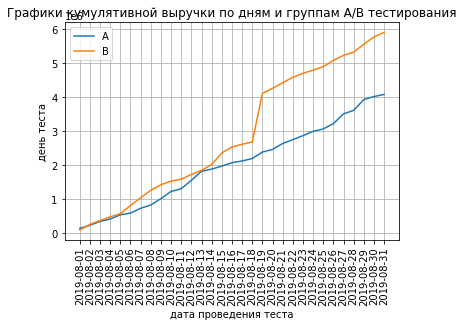

In [10]:
#Построим графики кумулятивной выручки по дням и группам A/B тестирования
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'buyers']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'buyers']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')


plt.title('Графики кумулятивной выручки по дням и группам A/B тестирования')
plt.ylabel('день теста')
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('дата проведения теста')
plt.legend() 
plt.show()

В начале эксперимента видно, что выручка сперва распределялась равномерно в 2-х группах, с некоторыми скачками, но потом группа B резко пошла на увеличение. Это может нам говорить об увеличении числа заказаов, либо об резком увеличении суммы заказаов(не исключено, что это могут быть и просто выбросы)

### График средней выручки по чекам

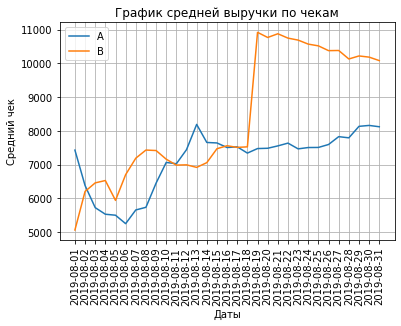

In [11]:
#Далее построим графики среднего чека по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['buyers'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['buyers'], label='B')
plt.legend() 
plt.title('График средней выручки по чекам')
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Даты')
plt.ylabel('Средний чек')
plt.show()

На графике видно, что среднее значение чека сильно изменяются и толькоближе к концу эксперимента они стабилизируются. Показатели группы B по отношению к показателям группы A отличаются значительно, так же на графике заметны сильные всплески, что больше похоже на выбросы.

### График относительного изменения кумулятивного среднего чека группы B к группе A

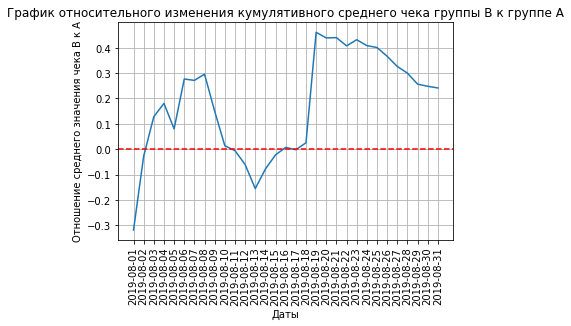

In [12]:
#Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline() 
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['buyersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['buyersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Даты')
plt.ylabel('Отношение среднего значения чека B к A')
plt.show()

В нескольких точках график сильно поднимается вверх, здесь точно есть большие заказы и выбросы.

### График куммулятивной конверсии по группам

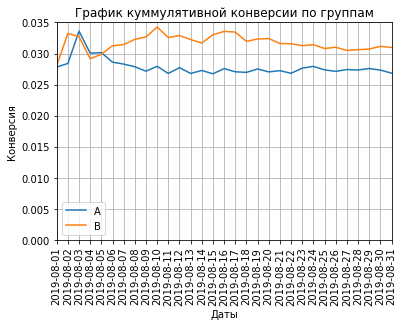

In [13]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['buyers'] / cumulativeData['visitors']
#display(cumulativeData.head(5))
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group'] =='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group'] =='B']
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График куммулятивной конверсии по группам')
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Даты')
plt.ylabel('Конверсия')
# задаем масштаб осей

plt.axis([cumulativeData_min,cumulativeData_max,0,0.035]) 
plt.show()

Симметричный график получился. Водном моменте группы начали одинаково,потом продолжили так же падатьвместе,только вот после падения группа B смогла восстановиться,а группа A продолжила падение,зафиксировав свое падение ближе к концу эксперимента.

### График относительного различия кумулятивных значений конверсий

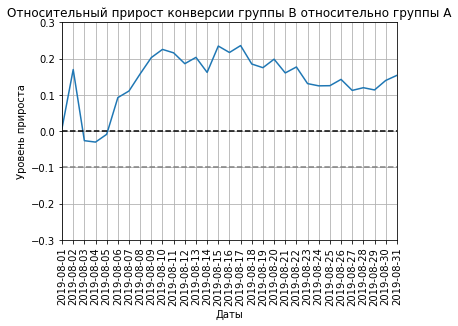

In [14]:
#Построим график относительного различия кумулятивных конверсий
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
#plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([cumulativeData_min, cumulativeData_max, -0.3, 0.3]) 
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Даты')
plt.ylabel('Уровень прироста')
plt.show()

Исследуя график видим, что в самом начале конверсия группы В по отношению  к другой группе возрастала,потом она упала,спустя какой-то промежуток времени она вновь начала увеличиваться. В целом значение конверсии еще не установилось и делать какие-либо окончательные выводы пока рано.

### График количества заказов по пользователям

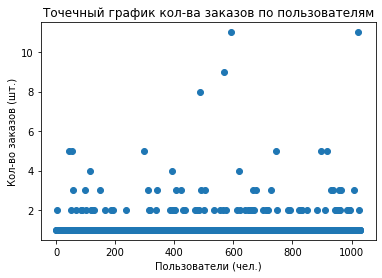

In [15]:
#Построим точечный график кол-ва заказов по пользователям
count_orders = clear_orders.groupby('visitor_id').agg({'visitor_id':'count'})
count_orders.columns = ['count']
#display(count_orders)
x_values = pd.Series(range(0,len(count_orders['count'])))
plt.scatter(x_values, count_orders['count']) 
plt.title('Точечный график кол-ва заказов по пользователям')
plt.xlabel('Пользователи (чел.)')
plt.ylabel('Кол-во заказов (шт.)')
plt.show()

Как и предпологал, есть пользователи, которые сделали заказов больше 4, можно предположить, что это и будет нижней границей выбросов.Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. Посмотрим так ли это на самом деле, вычислив перцентели 95-й и 99-й.

In [16]:
#Найдем перцентели заказов (95-й и 99-й)
print(np.percentile(count_orders['count'],[95,99]))

[2. 4.]


Не более 5% пользователей сделало заказов больше 2 и не более 1 % сделали 4 и более заказов.

### График стоимостей заказов

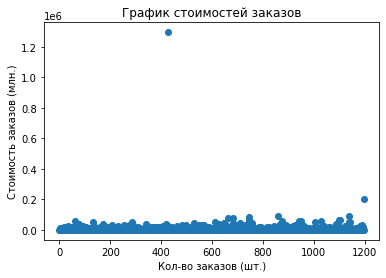

In [17]:
x2_values = pd.Series(range(0,len(clear_orders['revenue'])))
plt.scatter(x2_values, clear_orders['revenue']) 
plt.title('График стоимостей заказов')
plt.xlabel('Кол-во заказов (шт.)')
plt.ylabel('Стоимость заказов (млн.)')
plt.show()

Судя по графику можно сказать, что выбросов то и нету практически, посмотрим на процентное соотношение.

In [18]:
print(np.percentile(clear_orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказы дороже 28000 и не более 1 % заказы дороже 58233.

### Статистическая значимость различий в конверсии между группами(по сырым данным)

Для того, чтобы выполнять дальнейшие рассчеты необходимо сформулировать гипотезы, которые далее следует проверить
**Нулевая: различий в конверсии между группами нет.
Альтернативная: различия в конверсии между группами есть.**

In [43]:
visitsA, visitsB = visitors.query('group == "A"'), visitors.query('group == "B"')
ordersA = orders.query('group == "A"').groupby('visitor_id')\
                .agg({'transaction_id': 'nunique', 'revenue': 'sum'}).rename(columns = {'transaction_id': 'orders'})
ordersB = orders.query('group == "B"').groupby('visitor_id')\
                .agg({'transaction_id': 'nunique', 'revenue': 'sum'}).rename(columns = {'transaction_id': 'orders'})

# [0] * (visitsA['visitors'].sum() - ordersA.shape[0])
# это массив из нулей длинной visitsA['visitors'].sum() - ordersA.shape[0]
sampleA = ordersA['orders'].append(pd.Series([0] * (visitsA['visitors'].sum() - ordersA.shape[0]), name = 'orders'))
sampleB = ordersB['orders'].append(pd.Series([0] * (visitsB['visitors'].sum() - ordersB.shape[0]), name = 'orders'))


print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


Видим, что  число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Значит различия между группами наблюдается.

### Статистическая значимость различий в среднем чеке между группами(по сырым данным)

Теперь необходимо проверить статистическую значимость различий в среднем чеке между сегментами.Определим гипотезы.
**Нулевая гипотеза: различий в среднем чеке между группами нет.
Альтернативная гипотеза: различия в среднем чеке между группами есть.**

In [20]:
#Чтобы рассчитать статистическую значимость различий в среднем чеке, 
#передадим критерию mannwhitneyu() данные о выручке с заказов.
#А ещё найдём относительные различия в среднем чеке между группами:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


Нулевую гипотезу не отвергаем,т.к p-value = 0.729  больше 0.05( различий в среднем чеке нет).Впрочем, средний чек в группе В значительно выше среднего чека группы А.

In [21]:
#Найдем аномальных пользователей,т.е тех,кто совершил от 4-х заказов или совершил заказа дороже 28000
#display(ordersA.head(45))
#ordersA.info()
usersWithManyOrders = pd.concat(
    [
        ordersA[ordersA['orders'] >= 4]['orders'],
        ordersB[ordersB['orders'] >= 4]['orders'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

199603092             4
2038680547            5
2458001652            6
4256040402            7
1099          148427295
dtype: int64
(61,)


В результате получился всего **61** аномальный пользователь. Далее необходимобудет проверить как ихдействия повлияли на результаты теста.

### Статистическая значимость различий в конверсии между группами(по чистым данным)

Выполним необходимые рассчеты , сформулировав гипотезы, которые далее проверим.
**Нулевая: различий в конверсии между группами нет.
Альтернативная: различия в конверсии между группами есть.**

In [57]:
# Найдем Статистическая значимость различий в конверсии между группами используя чистые данные
#sampleAFiltered = ordersA['orders'].isin(abnormalUsers).append(pd.Series([0] * (visitsA['visitors'].sum() - ordersA.shape[0]), name = 'orders'))
#sampleBFiltered = ordersB['orders'].isin(abnormalUsers).append(pd.Series([0] * (visitsB['visitors'].sum() - ordersB.shape[0]), name = 'orders'))
orders_A =  (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
    .rename(columns = {'transaction_id': 'orders'})
)

orders_B =  (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
    .rename(columns = {'transaction_id': 'orders'})
)


sample_A_filtered = pd.concat([orders_A[np.logical_not(orders_A['visitor_id'].isin(abnormalUsers))]['orders'],
                    pd.Series(0,index=np.arange(visitsA['visitors'].sum() - len(orders_A['orders'])),
                    name='orders',),],axis=0,)

sample_B_filtered = pd.concat([orders_B[np.logical_not(orders_B['visitor_id'].isin(abnormalUsers))]['orders'],
                    pd.Series(0,index=np.arange(visitsB['visitors'].sum() - len(orders_B['orders'])),
                    name='orders',),],axis=0,)

print('{0:.3f}'.format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1)) 

0.019
0.140


Видим, что по "очищенным" данным, число — p-value = 0.019(по "неочищенным" данным p-value = 0.017, что значительно меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Значит различия между группами наблюдается.

### Статистическая значимость различий в конверсии между группами(по очищенным данным)

In [59]:
#print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'].isin(abnormalUsers), orders[orders['group']=='B']['revenue'].isin(abnormalUsers))[1]))
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)
#print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.863
-0.013


P-value увеличился  и разница между сегментами изменилась незначительно(с 1% до 1.3 %).

## Вывод

В ходе проведения эксперимента, на этапе предобработки данных не было выявлено дубликатов и пропусков в данных, были подкорректированы названия столбцов(приведены к единому стилю). Были расставлены приоритеты гипотез и выявлено, на какой из гипотез стоит сосредоточиться. Далее был проведен так называемый A/B тест. В ходе проведения этого теста(эксперимента) все покупатели интернет-магазина были поделены да 2 группы. Далее исследуя полученные группы выяснилось, что некоторые пользователи попали в 2 группы (уже на данном этапе можно было прервать эксперимент и пойти выяснять у менеджеров как так они оказались и там и тут?). После чего эксперимент продолжился, были проверены статистически значимые значения по "чистым" данным и по "грязным", опираясь на полученные значения, было принято решение, что эксперимент надо остановить, так разницы между группамисущественной нет, если не братьв рассчет то,что в группе В были "токсичные данные", которые мешали нормальному проведению эксперимента. Это можно так же было заметить по графику средней выручки по чекам(есть резкий скачок вверх).